## A simple self-contained notebook that performs **ACET training** on the Two Moons dataset using `tf-eager`

We can clearly see on this 2D example the problem of overconfident
predictions for plain ReLU-networks and the effect of ACET-training. 


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
tf.enable_eager_execution()


In [6]:
class Model(tf.keras.Model):
  def __init__(self):
    """ A simple two-hidden layer network. """
    super(Model, self).__init__()
    n_in = 2
    # for successful training, the network should be expressive enough
    n_hidden = [100, 100]
    n_classes = 2
    self.w1 = tfe.Variable(tf.random_normal([n_in, n_hidden[0]], stddev=tf.sqrt(2/n_in)), name='weight1')
    self.b1 = tfe.Variable(tf.zeros(n_hidden[0]), name='bias1')
    self.w2 = tfe.Variable(tf.random_normal([n_hidden[0], n_hidden[1]], stddev=tf.sqrt(2/n_hidden[0])), name='weight2')
    self.b2 = tfe.Variable(tf.zeros(n_hidden[1]), name='bias2')
    self.w3 = tfe.Variable(tf.random_normal([n_hidden[1], n_classes], stddev=tf.sqrt(2/n_hidden[1])), name='weight3')
    self.b3 = tfe.Variable(tf.zeros(n_classes), name='bias3')
    self.vars = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
      
  def call(self, x):
    l1 = tf.nn.relu(x @ self.w1 + self.b1)
    l2 = tf.nn.relu(l1 @ self.w2 + self.b2)
    l3 = l2 @ self.w3 + self.b3
    return l3


def cross_ent(logits, y):
    losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)


def max_conf(logits):
    y = tf.argmax(logits, 1)
    y = tf.one_hot(y, dim)
    losses = -tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)

def gen_adv(x):
    eps = 0.025
    n_iters = 4
    step_size = 0.02

    unif = tf.random_uniform(minval=-eps, maxval=eps, shape=tf.shape(x))
    x_adv = tf.clip_by_value(x + unif, 0., 1.)
    
    for i in range(n_iters):
        x_adv = tfe.Variable(x_adv)
        with tf.GradientTape() as tape:
            loss = max_conf(model(x_adv))
            grad = tape.gradient(loss, x_adv)
            g = tf.sign(grad)

        # import pdb;pdb.set_trace()
        x_adv_start = x_adv + step_size*g
        x_adv = tf.clip_by_value(x_adv, 0., 1.)
        delta = x_adv - x_adv_start
        delta = tf.clip_by_value(delta, -eps, eps)
        x_adv = x_adv_start + delta

    return x_adv


In [7]:
dim = 2
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.02)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75
y = tf.one_hot(y, depth=2)

model = Model()
# the default learning rate of Adam might not be the best for this dataset
optimizer = tf.train.AdamOptimizer(0.01)

# Training loop
acet = True
if acet:
    n_iter = 3000
else:
    n_iter = 400

for i in range(1, n_iter+1):
  X_noise = tf.random_uniform([2*X.shape[0], X.shape[1]])
  if acet:
    X_noise = gen_adv(X_noise)
  with tf.GradientTape() as tape:
    logits = model(X)
    logits_noise = model(X_noise)
    loss_main = cross_ent(logits, y)
    loss_acet = acet * max_conf(logits_noise)
    loss = loss_main + loss_acet
  grads = tape.gradient(loss, model.vars)
  optimizer.apply_gradients(zip(grads, model.vars), global_step=tf.train.get_or_create_global_step())
  if i % 100  == 0:
    train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
    print("Iter {:03d}: loss_main={:.3f} loss_acet={:.3f} err={:.2%}".format(i, loss_main, loss_acet, train_err))



Iter 100: loss_main=0.298 loss_acet=-0.401 err=14.50%
Iter 200: loss_main=0.294 loss_acet=-0.451 err=16.15%
Iter 300: loss_main=0.263 loss_acet=-0.439 err=1.85%
Iter 400: loss_main=0.256 loss_acet=-0.441 err=16.50%
Iter 500: loss_main=0.232 loss_acet=-0.455 err=5.10%
Iter 600: loss_main=0.137 loss_acet=-0.445 err=0.00%
Iter 700: loss_main=0.068 loss_acet=-0.447 err=0.00%
Iter 800: loss_main=0.055 loss_acet=-0.434 err=0.00%
Iter 900: loss_main=0.050 loss_acet=-0.477 err=0.00%
Iter 1000: loss_main=0.050 loss_acet=-0.498 err=0.00%
Iter 1100: loss_main=0.033 loss_acet=-0.490 err=0.00%
Iter 1200: loss_main=0.035 loss_acet=-0.495 err=0.00%
Iter 1300: loss_main=0.034 loss_acet=-0.494 err=0.00%
Iter 1400: loss_main=0.036 loss_acet=-0.500 err=0.00%
Iter 1500: loss_main=0.031 loss_acet=-0.506 err=0.00%
Iter 1600: loss_main=0.029 loss_acet=-0.501 err=0.00%
Iter 1700: loss_main=0.031 loss_acet=-0.522 err=0.00%
Iter 1800: loss_main=0.024 loss_acet=-0.534 err=0.00%
Iter 1900: loss_main=0.030 loss_ac

In [8]:
def plot(model, plot_min, plot_max, max_prob):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    logits = model(points)
    probs = tf.nn.softmax(logits).numpy()
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y)
    X0 = X[y_np.argmax(1)==0]
    X1 = X[y_np.argmax(1)==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('plots/toy2d_acet={}_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
        acet, plot_min, plot_max, max_prob), transparent=True)
    plt.show()


We can see that ACET is effective in the zero-one box, but if we zoom out
we are still able to find overconfident predictions as predicted by Theorem 1.

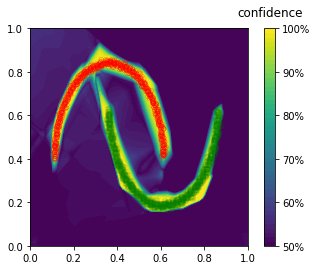

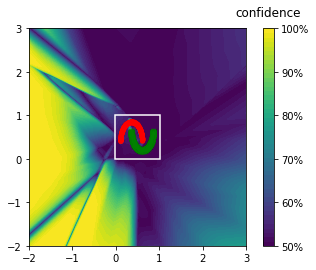

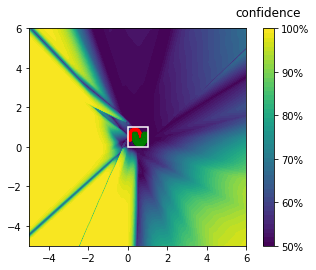

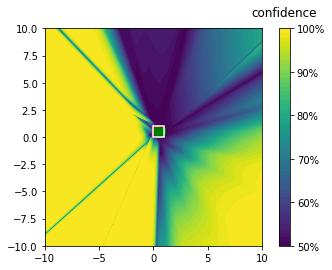

In [9]:
plot(model, 0.0, 1.0, max_prob=True)
plot(model, -2.0, 3.0, max_prob=True)
plot(model, -5.0, 6.0, max_prob=True)
plot(model, -10.0, 10.0, max_prob=True)
